## Signatures

Sung Cheol Yoon - 3037932926 \
Tien Hung (August) Nguyen - 3036511141

## Importing packages 

In [58]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import animation, rc
#sns.set_context('poster')
from scipy.stats import poisson
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import chi2
import h5py
import scipy.integrate as integrate
import numpy.random as random
import time
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from numpy.fft import fft, ifft
from scipy.stats import poisson

## Setting User Parameters

In [104]:
# The number of Bins used to discriminate between observed masses
Bins = 200

# The number of parameter tuning iterations when fitting our 
#model (i.e. polynomial+normal distribution) to the data
Iterations = 20

# The order of the polynomial used to model the background hypothesis
Degrees = 9

# The range of masses in the observed data that are "filtered" when
#fitting the background model. 
Train_Range = [120, 130]

# The number of pseudo experiments
Pseudo_experiments = 100

# The number of parameter tuning iterations in pseudo experiments
Pseudo_Iterations = 1

# The number of parameter tuning iterations when testing the 
#performance of various fitting methods. 
Comp_Iterations = 10

# The range of Bins scanned-through to test the performance of 
#various fitting methods.
Bin_list = np.linspace(10, 500, 10)

## Importing Data

In [60]:
# Open h5 file
h = h5py.File("datalhc.h5",'r')

# Retrieve the data array 
data = h["dataset"][:]

# Check its shape
#print(data.shape)

# Here a few functions are defined to get the px, py, pz components of the momentum

def px(pt, phi):
    return pt*np.cos(phi)

def py(pt, phi):
    return pt*np.sin(phi)

def pz(pt, eta):
    return pt*np.sinh(eta)

# Using energy and momentum we can calculate the mass of a particle or a multi-particle system
def mass(E,px,py,pz):
    return np.sqrt(E**2-(px**2+py**2+pz**2))

# We will use the functions defined above to calculate 
# the px, py, pz components of the diphoton momentum

px_yy = px(data[:,0],data[:,2])+px(data[:,4],data[:,6])
py_yy = py(data[:,0],data[:,2])+py(data[:,4],data[:,6])
pz_yy = pz(data[:,0],data[:,1])+pz(data[:,4],data[:,5])

# We will also calculate the energy of the diphoton system
# which is the sum of individual photons
E_yy = data[:,3]+data[:,7]

# Finally, we can calculate the diphoton mass
m_yy = mass(E_yy, px_yy, py_yy, pz_yy)

## Defining key functions

In [61]:
# Density functions (up to a factor)

def density_bkg(c,myy):
    """
    A polynomial function (the order is not fixed) used to represent
    the probability density function (up to a factor) of observing 
    mass 'myy'. 'c' are the coefficients in the polynomial.
    """
    function = 0
    for i in range(Degrees+1):
        function += c[i]*myy**i
    return function
    
def density_sig(c2,myy):
    """
    A normal distribution used to represent the probability density
    function (up to a factor) of "observing" a Higgs Boson at mass 'myy'. 
    'c2' define the mean, standard deviation, and weight of the signal.
    """
    return norm.pdf(myy,c2[0],c2[1])*c2[2]

# The integral (exact or approximate) of the density functions

def int_density_bkg(c, bin_edges):
    """
    The analytical integral of the probability density function of the 
    background hypothesis between each bin edges. 
    """
    lower_bounds = bin_edges[:-1]
    upper_bounds = bin_edges[1:]
    
    def ind_int(x):
        """
        The indefinite integral of 'density_bkg'  
        """
        intg = 0
        for i in range(Degrees+1):
            intg += c[i]/(i+1)*x**(i+1)
        return intg
        
    return ind_int(upper_bounds)-ind_int(lower_bounds)

def int_density_sig(c2,bin_edges):
    """
    An approximate integral of the "signal" probability density function between
    each bin edges. 
    """
    lower_bounds = bin_edges[:-1]
    upper_bounds = bin_edges[1:]
    
    def ind_int2(x):
        """
        As the analytical integral of a normal distribution is unknown, scipy's
        norm.cdf is used to estimate the cumulative density function at 'x'
        """
        return norm.cdf(x,c2[0],c2[1])*c2[2]
        
    return ind_int2(upper_bounds)-ind_int2(lower_bounds)

# The negative log likelihood (NLL) values between the observed data and our models

def NLLpoly(c, obs, bin_edges): 
    """
    The negative log likelihood between the observed data and our background-
    only hypothesis, given a set of parameters 'c', observation data 'obs', and
    the bin edges used to categorize the observation data
    """
    exp = int_density_bkg(c, bin_edges)
    binwidth = bin_edges[1]-bin_edges[0]
    return -1*poisson.logpmf(obs,exp/binwidth).sum()

def NLLSpluspolyfree(csig, c, obs, bin_edges):
    """
    The negative log likelihood between the signal+background model, where
    'csig' are the parameters of the signal ('c2' in 'density_sig'), and 'c'
    contain the parameters of the background only hypothesis. 
    """
    exp2 = int_density_sig(csig,bin_edges) + int_density_bkg(c,bin_edges) 
    binwidth = bin_edges[1]-bin_edges[0]
    return -1*poisson.logpmf(obs,exp2/binwidth).sum()

def Bkg_Fit_Filtered(c, obs, bin_edges, filter_range):   
    """
    The negative log likelihood between the background-only hypothesis
    and a filtered version of the observed data. The 2 elements of 
    'filter_range' define the start and end points of the truncation.
    """
    exp = int_density_bkg(c, bin_edges)
    binwidth = bin_edges[1]-bin_edges[0]
    
    lower_indices = np.where(bin_edges > filter_range[0])[0]
    upper_indices = np.where(bin_edges < filter_range[1])[0]
    filtered_indices = np.intersect1d(lower_indices, upper_indices)
    
    filtered_obs = np.delete(obs, filtered_indices)
    filtered_exp = np.delete(exp, filtered_indices)
    
    return -1*poisson.logpmf(filtered_obs,filtered_exp/binwidth).sum()
#-----------------------------------------------------------------------------------------
def residual_func(c, csig, obs, bin_edges):
    """
    The residual (difference) between the observation and model (either 
    background-only or bkg+sig)
    """
    exp_bkg = int_density_bkg(c,bin_edges)
    
    # if csig is not declared, we assume the user wants the residual between
    #the data and the bkg-only model
    if csig[0] == None:
        exp = exp_bkg
    # otherwise, we assume they want the residual between the data and the
    #bkg+sig model.
    else:
        exp = exp_bkg+int_density_sig(csig,bin_edges)
    
    binwidth = bin_edges[1]-bin_edges[0]
    return obs-exp/binwidth

def cleaner(array, N):
    """
    Outputs the running average of an array
    """
    N = int(N)
    if N%2 != 0:
        N += 1
    return np.convolve(array, np.ones(N)/N, mode='valid')

def clean_plotter(array,N):
    """
    Using running averages, "smoothes" a given function, for readability
    """
    N = int(N)
    if N%2 != 0:
        N += 1
    sli = int(N/2)
    X = myy[sli:-(sli-1)]
    
    plt.plot(X,cleaner(array,N),label='smoothed residual')
    plt.plot(X,np.zeros(len(X)))
    plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
    plt.ylabel('Events-(Bkg+Sig)')
    plt.legend()
    plt.show()

def fit_visualizer(c1, c2, smoothing = 4):
    """
    Plots the graph of either the bkg-only model or both it and the bkg+sig model, 
    alongside the residual.
    """
    fit = density_bkg(c1, myy)
    
    if c2[0] != None:
        fit2 = density_bkg(c1,myy) + density_sig(c2,myy)
        plt.plot(myy,fit2,'r--', label='bkg+sig',color='blue')
    
    res = residual_func(c1,c2,obs_data,obs_binedges)
    plt.hist(m_yy,bins=Bins,range=(Range[0],Range[1]), label='data',color='green')
    plt.plot(myy,fit,'r--', label='bkg',color='red')
    plt.plot(myy,res,'r--', label='residual',color='yellow')

    plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
    plt.ylabel('Number of entries')
    plt.legend()
    plt.show()
    
    clean_plotter(res,smoothing)
#-----------------------------------------------------------------------------------------
Range = [np.amin(m_yy), np.amax(m_yy)]
obs_data, obs_binedges, others = plt.hist(m_yy, bins=Bins, range=(Range[0],Range[1]))
plt.close()
myy = np.linspace(Range[0],Range[1],Bins)

## Background fit onto filtered data

In [62]:
# Making an initial guess for the bkg-only parameters (coefficients of the polynomial)
#using Least Squares regression, using filtered data
lower_indices = np.where(myy > Train_Range[0])[0]
upper_indices = np.where(myy < Train_Range[1])[0]
filtered_indices = np.intersect1d(lower_indices, upper_indices)

filtered_obs = np.delete(obs_data, filtered_indices)
filtered_myy = np.delete(myy, filtered_indices)

mu_f = np.flip(np.polyfit(filtered_myy, filtered_obs, Degrees))

# Performing the fit, 'Iterations' number of times
for i in range(Iterations):
    result_train = minimize(Bkg_Fit_Filtered, mu_f, args=(obs_data, obs_binedges, Train_Range), method='Nelder-Mead')
    mu_f = result_train.x

print("Background parameters: ",mu_f)

Background parameters:  [-7.37132289e+08  4.81449822e+07 -1.38810008e+06  2.31840294e+04
 -2.47140894e+02  1.74316741e+00 -8.13191304e-03  2.41817077e-05
 -4.15663785e-08  3.14412715e-11]


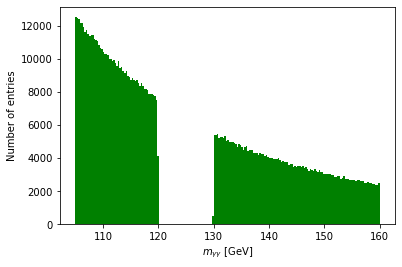

In [63]:
# Visual representation of the filtering method (this cell is not directly used for calculations.)

lower_indices_display = np.where(m_yy > Train_Range[0])[0]
upper_indices_display = np.where(m_yy < Train_Range[1])[0]
indices_display = np.intersect1d(lower_indices_display, upper_indices_display)

display_filtered_obs = m_yy.copy()
display_filtered_obs[indices_display] = 0

plt.hist(display_filtered_obs,bins=Bins,range=(Range[0],Range[1]),label='filtered data',color='green')
plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
plt.ylabel('Number of entries')
plt.show()

## Signal fit

In [64]:
# Fitting only the signal model to the observed data, having the background-only hypothesis fixed

sig_mu = [125, 2, 3*10**5/Bins]

for i in range(Iterations):
    result_train = minimize(NLLSpluspolyfree, sig_mu, args=(mu_f, obs_data, obs_binedges), method='Nelder-Mead')
    sig_mu = result_train.x

print("Signal Parameters: ", sig_mu)

Signal Parameters:  [ 125.42515375    1.38973185 1258.3458527 ]


## Testing fit against observation data

In [65]:
NLLbackground = NLLpoly(mu_f, obs_data, obs_binedges)
NLLmufree_obs = result_train.fun

print("Background-only NLL: ", NLLbackground)
print("Background+Signal NLL: ", NLLmufree_obs)

#fit_visualizer(mu_f, sig_mu, 3)

Background-only NLL:  1216.8794940620242
Background+Signal NLL:  1127.0138428315308


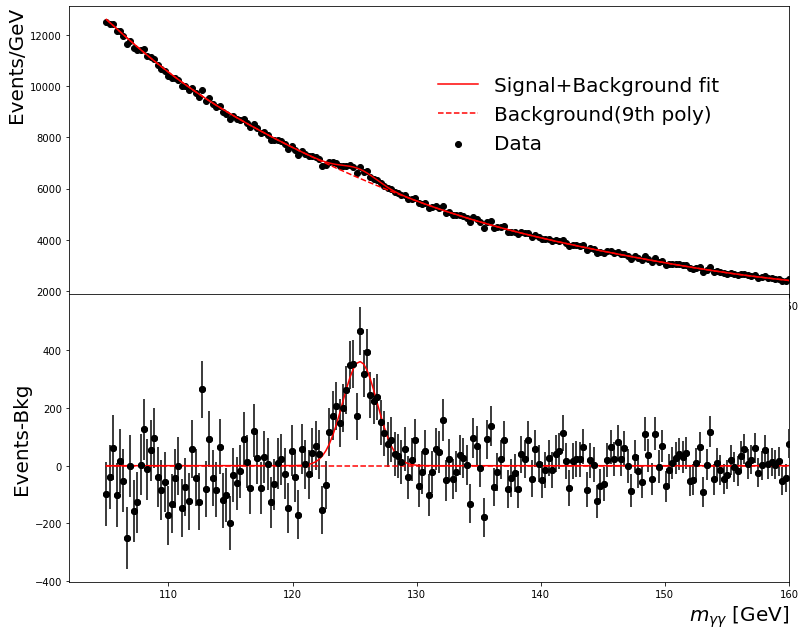

In [66]:
'''label data specific value'''
sig = density_sig(sig_mu, myy)
bkg = density_bkg(mu_f, myy)
fit = sig +bkg
obs = obs_data
residual = obs - bkg

fig, axs = plt.subplots(2,1,figsize=(10,8), gridspec_kw={'height_ratios': [3, 1]})
markerstyle = 'o' 
markercolor = 'black'
markersize = 100

plt.subplot(211)
plt.plot(myy,fit,color = "red", label='Signal+Background fit')
plt.plot(myy,bkg,'r--', label='Background(9th poly)')
plt.scatter(myy,obs,color = "black", label='Data')
plt.xlim(102, 160)
plt.ylabel('Events/GeV',horizontalalignment='right',y=1.0, fontsize=20)
plt.text( 135,550, r'$H \rightarrow \gamma\gamma$',fontsize=20)
plt.legend(borderpad=3,fontsize=20,frameon=False, loc='upper right')

plt.subplot(212)

plt.plot(myy,fit - fit,'r--')
plt.scatter(myy,residual,color = "black", label='Data')
plt.xlim(102,160)
plt.xlabel('$m_{\gamma\gamma}$ [GeV]', horizontalalignment='right',x=1.0, fontsize=20)
plt.ylabel('Events-Bkg', fontsize = 20)

error =(obs)**0.5
plt.errorbar(myy, residual, yerr=error, fmt=markerstyle,color=markercolor)
plt.plot(myy,(sig), color="red")


plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

## Calculating the PLR for the observed data

In [67]:
PLR_obs = 2*(NLLbackground -  NLLmufree_obs)
print("PLR: ",PLR_obs)

Z = PLR_obs**0.5
# This is how you get pvalue, knowing Z
pvalue = 1-norm.cdf(Z)
print('p-value of the background-only hypothesis is {:1.2f}'.format(pvalue))
print('the Statistical significance of rejecting the background only hypothesis is {:1.2f}'.format(Z))

PLR:  179.73130246098663
p-value of the background-only hypothesis is 0.00
the Statistical significance of rejecting the background only hypothesis is 13.41


## Comparison with competiting methods

### 1/3: United vs Filtered fit

In [68]:
def Unified_Fit(c, obs, bin_edges):
    """
    NLL function between the observed data 'obs' and the Bkg+Sig model
    """
    cpt1 = c[0:Degrees+1]
    cpt2 = c[Degrees+1:Degrees+4] 
    return NLLSpluspolyfree(cpt2, cpt1, obs, bin_edges)

def United_vs_Filtered(Bins0, Iterations=Comp_Iterations):
    """
    A function used to compare the performance (minimum NLL, runtime) between the 
    data-filtering method and the regular "united" fitting method
    """
    Bins0 = int(Bins0)
    obs_data0, obs_binedges0, others = plt.hist(m_yy, bins=Bins0, range=(Range[0],Range[1]))
    plt.close()
    myy0 = np.linspace(Range[0],Range[1],Bins0)
    #-----------------------------------------------------------------
    # Making an initial guess for the united fitting method 
    
    mu_f0 = np.flip(np.polyfit(myy0, obs_data0, Degrees))
    sig_mu0 = [125, 2, 3*10**5/Bins0]
    guess0 = np.hstack((mu_f0, sig_mu0))
    #-----------------------------------------------------------------
    # Fitting all 'Dimensions+4' parameters "at once"
    
    t1 = time.time()

    for i in range(Iterations):
        result_train = minimize(Unified_Fit, guess0, args=(obs_data0, obs_binedges0), method='Nelder-Mead')
        guess0 = result_train.x

    t2 = time.time()

    free = result_train.fun
    #-----------------------------------------------------------------
    # Making an initial guess for the filter-fitting method
    lower_indices = np.where(myy > Train_Range[0])[0]
    upper_indices = np.where(myy < Train_Range[1])[0]
    filtered_indices = np.intersect1d(lower_indices, upper_indices)

    filtered_obs = np.delete(obs_data, filtered_indices)
    filtered_myy = np.delete(myy, filtered_indices)

    mu_f00 = np.flip(np.polyfit(filtered_myy, filtered_obs, Degrees))
    sig_mu00 = sig_mu0.copy()
    #-----------------------------------------------------------------
    # Fitting the parameters, for the background (mu_f00) and signal(sig_mu00) separately
    
    for i in range(Iterations):
        result_train = minimize(Bkg_Fit_Filtered, mu_f00, args=(obs_data0, obs_binedges0, Train_Range), method='Nelder-Mead')
        mu_f00 = result_train.x

    for i in range(Iterations):
        result_train = minimize(NLLSpluspolyfree, sig_mu00, args=(mu_f00, obs_data0, obs_binedges0), method='Nelder-Mead')
        sig_mu00 = result_train.x

    return free-result_train.fun, t2-t1, free, guess0

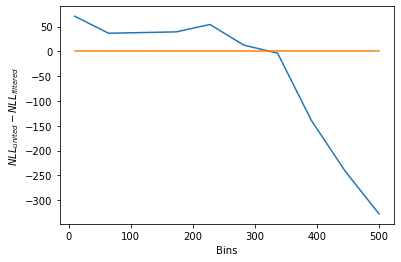

In [69]:
# Creating arrays to store the calculations made in the below for-loop (to compare the united vs. filtering method)
NLLComp = np.ones(len(Bin_list))
Runtime_Analy = np.ones(len(Bin_list))
NLL_Analy = np.ones(len(Bin_list))
Param = np.ones((len(Bin_list),Degrees+4))

for i in range(len(Bin_list)):
    # NLLComp is used to check the difference in optimized NLL between the two methods
    #Runtime_Analy, NLL_Analy are used in the test below between numerical vs. analytical integration methods in calculating NLL
    NLLComp[i], Runtime_Analy[i], NLL_Analy[i], Param[i] = United_vs_Filtered(Bin_list[i])
    
plt.plot(Bin_list, NLLComp)
plt.plot([Bin_list[0], Bin_list[-1]], [0,0])
plt.xlabel("Bins")
plt.ylabel("$NLL_{united}-NLL_{filtered}$")
plt.show()

### 2/3: Numerical vs Analytical integration in the NLL function

In [70]:
def int_density_num(func, C, bin_edges):
    """
    General numerical integration function to integrate probability 
    density functions between each bin edges. 
    """
    intarray = np.ones(len(bin_edges)-1)
    def compactfunc(x):
        """
        Reducing the input function to a single variable function
        """
        return func(C, x)
    for i in range(len(bin_edges)-1):
        # Using Scipy's Gaussian Quadrature method of integration.
        intarray[i] = integrate.quad(compactfunc, bin_edges[i],bin_edges[i+1])[0]
    return intarray

def NLLSpluspolyfree_num(csig, c, obs, bin_edges):
    """
    NLL between the Bkg+Sig model and the observed data, calculated using 
    'int_density_num' rather than 'int_density_bkg', etc.
    """
    exp2 = int_density_num(density_bkg, c, bin_edges) + int_density_num(density_sig, csig, bin_edges)
    binwidth = bin_edges[1]-bin_edges[0]
    return -1*poisson.logpmf(obs,exp2/binwidth).sum()

def Unified_Fit_num(c, obs, bin_edges):
    """
    NLL function between the observed data 'obs' and the Bkg+Sig model.
    Uses numerical integration to calculate NLL.
    """
    cpt1 = c[0:Degrees+1]
    cpt2 = c[Degrees+1:Degrees+4] 
    return NLLSpluspolyfree_num(cpt2, cpt1, obs, bin_edges)

def Num_vs_Analy(Bins0, Iterations):
    """
    A function used to compare the performance (minimum NLL, runtime) between the two
    methods of calculation NLLs we considered: analytical + cdf, or Gaussian Quadrature.
    Most of the data on the analytical+cdf method is already collected from the 
    'United_vs_Filtered' function above.
    """
    Bins0 = int(Bins0)
    
    obs_data0, obs_binedges0, others = plt.hist(m_yy, bins=Bins0, range=(Range[0],Range[1]))
    plt.close()
    myy0 = np.linspace(Range[0],Range[1],Bins0)
    #-----------------------------------------------------------------
    # Making an initial guess
    mu_f0 = np.flip(np.polyfit(myy0, obs_data0, Degrees))
    sig_mu0 = [125, 2, 3*10**5/Bins0]
    guess0 = np.hstack((mu_f0, sig_mu0))
    #-----------------------------------------------------------------
    t1 = time.time()

    # fitting parameters
    for i in range(Iterations):
        result_train = minimize(Unified_Fit_num, guess0, args=(obs_data0, obs_binedges0), method='Nelder-Mead')
        guess0 = result_train.x

    t2 = time.time()

    pt1 = guess0[0:Degrees+1]
    pt2 = guess0[Degrees+1:Degrees+4] 

    free = NLLSpluspolyfree(pt2, pt1, obs_data0, obs_binedges0)
    
    return [free,t2-t1]

In [71]:
# WARNING: The runtime of the below comparison is extremely long. 
#For the time being, only an estimate runtime of the numerical NLL
#calculations are printed in this cell.

"""
NLL_Num = np.ones(len(Bin_list))
Runtime_Num = np.ones(len(Bin_list))

for i in range(len(Bin_list)):
    NLL_Num[i], Runtime_Num[i] = Num_vs_Analy(Bin_list[i])
    
plt.plot(Bin_list, NLL_Num-NLL_Analy)
plt.plot(Bin_list, Runtime_Num-Runtime_Analy)

plt.show()
"""
Est_Single_Runtime = Num_vs_Analy(1,1)[1]
   
print("The estimated total runtime is: {:.2f} hours".format(Est_Single_Runtime*Bins*Iterations*1/(60**2)))

The estimated total runtime is: 2.59 hours


### 3/3: Arbitrary vs Least squares guessing

#### Issue Type 1

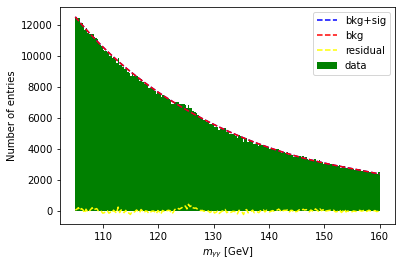

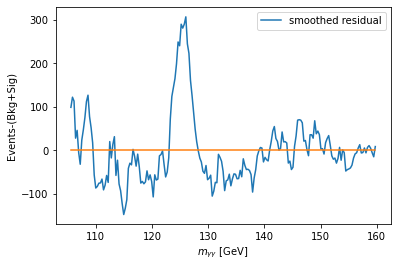

In [72]:
# Making an initial guess

guess1 = np.ones(Degrees+1)*1e-10
guess2 = np.array([125, 2, 100])
guess = np.hstack((guess1, guess2))
#-----------------------------------------------------------------
# Fitting parameters 

for i in range(Iterations):
    result_train = minimize(Unified_Fit, guess, args=(obs_data, obs_binedges), method='Nelder-Mead')
    guess = result_train.x

pt1 = guess[0:Degrees+1]
pt2 = guess[Degrees+1:Degrees+4] 

free = NLLSpluspolyfree(pt2, pt1, obs_data, obs_binedges)

fit_visualizer(pt1, pt2, 3)

#### Issue Type 2

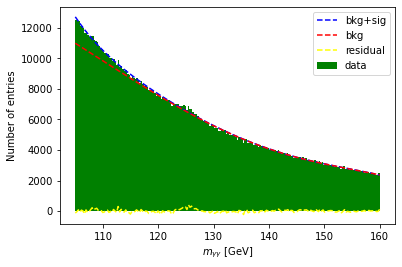

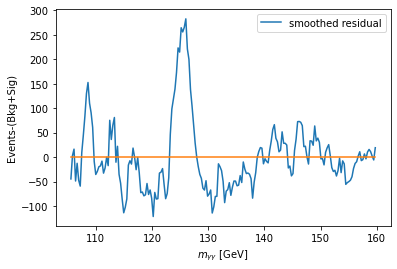

In [73]:
# Making an initial guess

guess1 = np.ones(Degrees+1)*1e-10
guess2 = np.array([125, 2, 1e7])
guess = np.hstack((guess1, guess2))
#-----------------------------------------------------------------
# Fitting parameters 

for i in range(Iterations):
    result_train = minimize(Unified_Fit, guess, args=(obs_data, obs_binedges), method='Nelder-Mead')
    guess = result_train.x

pt1 = guess[0:Degrees+1]
pt2 = guess[Degrees+1:Degrees+4] 

free = NLLSpluspolyfree(pt2, pt1, obs_data, obs_binedges)

fit_visualizer(pt1, pt2, 3)

## Verification of the p-value and significance using pseudo experiments

In [78]:
# Generate Pseudo experiments from b-only hypothesis

B_ = density_bkg(mu_f, myy)

rng = np.random.default_rng(14)
BPE = rng.poisson(B_.reshape(1,Bins),size=(Pseudo_experiments,Bins))

In [81]:
# all the PLR values from the P.E.s will be stored in the numpy array PLR
PLR = np.ones(0)

#-----------------------------------------------------------------
# Making an initial guess
PE_guess = np.hstack((mu_f,sig_mu))
#-----------------------------------------------------------------
for PE in BPE:
    # Write your code to calculate the PLR for this current PE
    for i in range(Pseudo_Iterations):
        PE_result = minimize(Unified_Fit, PE_guess, args=(PE, obs_binedges), method='Nelder-Mead')
        PE_guess = PE_result.x

    NLLmufree_PE = PE_result.fun
    NLLB = NLLpoly(mu_f, PE, obs_binedges)
    PLR_PE = 2*(NLLB-NLLmufree_PE)
    PLR = np.hstack((PLR, PLR_PE))

In [82]:
pvalue = len(PLR[np.where(PLR > PLR_obs)])/len(PLR)
Z = norm.ppf(1-pvalue)
print('p-value of the background-only hypothesis is {:1.4f}'.format(pvalue))
print('the Statistical significance of rejecting the background only hypothesis is {:1.2f}'.format(Z))

p-value of the background-only hypothesis is 0.0000
the Statistical significance of rejecting the background only hypothesis is inf


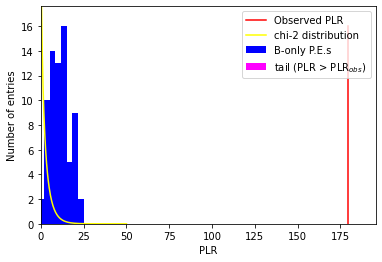

In [108]:
obs_pe, binedges_pe, others = plt.hist(PLR,bins=int(len(PLR)/2),label='B-only P.E.s',color='blue')

plt.hist(PLR[np.where(PLR > PLR_obs)],bins=Bins,\
         color='magenta',label='tail (PLR > PLR$_{obs}$)')

#plt.yscale('log')
plt.plot([PLR_obs,PLR_obs],[0,np.amax(obs_pe)], label='Observed PLR',color='red')

plt.xlim(0,None)
plt.ylim(0,np.amax(obs_pe)*1.1)

plt.xlabel('PLR')
plt.ylabel('Number of entries')

# Generating a chi-2 distribution as a reference
chi2_curve = chi2.pdf(np.linspace(0.5,24.5,Bins),1)*0.5*PLR.size
plt.plot(np.linspace(0,50,Bins), chi2_curve,label='chi-2 distribution',color='yellow')


plt.legend(loc='upper right')
plt.show()

## Determining the Higgs boson mass via an NLL scan

In [106]:
# creating a range of values for the Higgs Boson Mass
mu = np.linspace(120,130,3001)

# finding the NLLR for each hypothesis (a function of Mass), 
#for all Mass values in our selected range
NLLR_mu = np.ones(len(mu))
newsig = sig_mu.copy()

for i in range(len(mu)):
    newsig[0] = mu[i]
    NLLR_mu[i] = NLLSpluspolyfree(newsig, mu_f, obs_data, obs_binedges)

deltaLL = NLLR_mu-np.amin(NLLR_mu)

#locating mu for which deltaLL is minimized
mu_measured = mu[np.where(deltaLL == 0)][0]

#locating the mu values (which in this case is simply mass) 1 standard deviation away from the central value
mu_1std = mu[np.where(deltaLL-1<1e-3)]
mu_lo = np.amin(mu_1std)
mu_hi = np.amax(mu_1std)


print("The central value of mu is {:4.2f}".format(mu_measured))
print("The minus one sigma error of mu is {:4.2f}".format(mu_lo - mu_measured))
print("The plus one sigma error of mu is {:4.2f}".format(mu_hi - mu_measured))

The central value of mu is 125.41
The minus one sigma error of mu is -0.20
The plus one sigma error of mu is 0.20


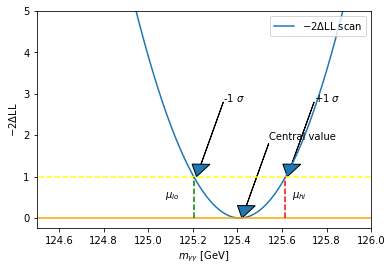

In [107]:
# plotting deltaLL as a function of mu
plt.plot(mu, deltaLL, label='$-2\Delta$LL scan')

# limiting and labeling the axes
plt.xlim(124.5, 126)
plt.ylim(-0.25,5)
plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
plt.ylabel('$-2\Delta$LL')

# setting parameters for visual elements (arrow length, 
#arrow head length, text position adjustment, etc)
dx = 0.1
dy = 1.5
head_wid = 0.08
head_len = 0.3
arrow_adjust_x = 0.03
arrow_adjust_y = 0.30

# adding arrows for annotation
plt.arrow(mu_measured+dx+arrow_adjust_x, dy+arrow_adjust_y, -dx, -dy, head_width = head_wid, head_length = head_len)
plt.arrow(mu_lo+dx+arrow_adjust_x, 1+dy+arrow_adjust_y, -dx, -dy, head_width = head_wid, head_length = head_len)
plt.arrow(mu_hi+dx+arrow_adjust_x, 1+dy+arrow_adjust_y, -dx, -dy, head_width = head_wid, head_length = head_len)

# adding lines for annotation
plt.plot([120, 130],[1,1],color='yellow', linestyle='dashed')
plt.plot([120, 130],[0,0],color='orange', linestyle='solid')
plt.plot([mu_lo, mu_lo],[0,1],color='green', linestyle='dashed')
plt.plot([mu_hi, mu_hi],[0,1],color='red', linestyle='dashed')

# adding a legend to the plot
plt.legend(loc = 'upper right')

# adding text labels
plt.text(mu_measured+dx+arrow_adjust_x,dy+arrow_adjust_y+0.1,'Central value')
plt.text(mu_lo+dx+arrow_adjust_x,1+dy+arrow_adjust_y,'-1 $\sigma$')
plt.text(mu_hi+dx+arrow_adjust_x,1+dy+arrow_adjust_y,'+1 $\sigma$')
plt.text(mu_lo-0.13,0.5,'$\mu_{lo}$')
plt.text(mu_hi+0.03,0.5,'$\mu_{hi}$')

plt.show()

## Sonification of Higgs Boson 

In [96]:
'''Change the Bins for suitable hearing frequency/rate and calculation data to the appropriate bins'''
Bins = 10000
Range = [np.amin(m_yy), np.amax(m_yy)]
obs_data, obs_binedges, others = plt.hist(m_yy, bins=Bins, range=(Range[0],Range[1]))
plt.close()
myy = np.linspace(Range[0],Range[1],Bins)
lower_indices = np.where(myy > Train_Range[0])[0]
upper_indices = np.where(myy < Train_Range[1])[0]
filtered_indices = np.intersect1d(lower_indices, upper_indices)

filtered_obs = np.delete(obs_data, filtered_indices)
filtered_myy = np.delete(myy, filtered_indices)

mu_f = np.flip(np.polyfit(filtered_myy, filtered_obs, Degrees))
#-----------------------------------------------------------------

for i in range(10):
    result_train = minimize(Bkg_Fit_Filtered, mu_f, args=(obs_data, obs_binedges, Train_Range), method='Nelder-Mead')
    mu_f = result_train.x

sig_mu = [125, 2, 3*10**5/Bins]

for i in range(10):
    result_train = minimize(NLLSpluspolyfree, sig_mu, args=(mu_f, obs_data, obs_binedges), method='Nelder-Mead')
    sig_mu = result_train.x
sig = density_sig(sig_mu, myy)
bkg = density_bkg(mu_f, myy)
fit = sig +bkg
obs = obs_data
residual = obs - bkg

## Graphing the residual data

Text(0, 0.5, 'Residue')

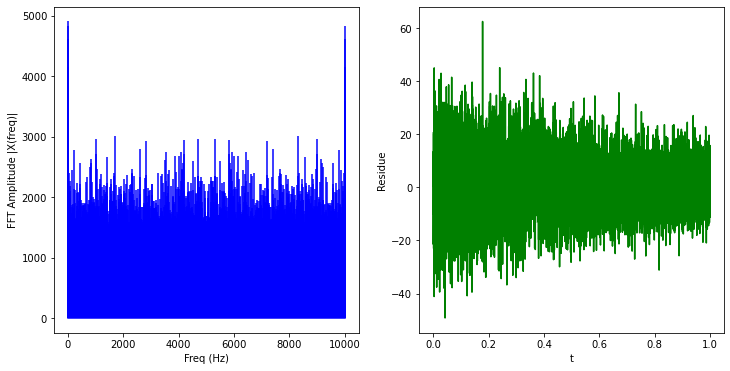

In [109]:
#obj = sig

obj = residual
sr= len(obj)
#obj = obs_data
t = np.arange(0,1,1/sr)

X = fft(obj)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T

'''Use ftt to graph out frequency'''

plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

plt.subplot(122)
plt.plot(t, obj , 'g')
plt.xlabel('t')
plt.ylabel('Residue')

As we can see, the wave doesn't look feasible. In order to fix this we need to smooth out the wave using Signal Butter

Text(0, 0.5, 'Residue')

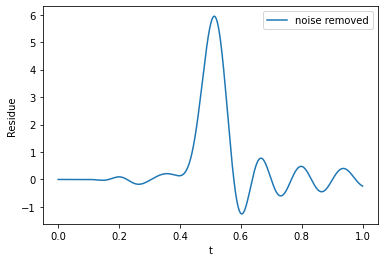

In [110]:
from scipy import signal  

sos = signal.butter(10, 8, 'lp', fs=10000, output='sos')
f_y1 = signal.sosfilt(sos,obj)

plt.plot(t, f_y1, label="noise removed")
plt.legend(loc = "upper right")

plt.xlabel('t')
plt.ylabel('Residue')

We can see that the graph look more feasible. Now we move turn this sound into a wave

In [99]:
from IPython.display import Audio
from scipy.io.wavfile import write

Audio(f_y1, rate = len(f_y1))

## Signal Strength

Identify likelikehood function

In [100]:
def logPoisson( k, Lambda ):
    return poisson.logpmf(k, Lambda)

In [101]:
NLL = -logPoisson(obs, sig) #NLL Value 
ns = np.linspace(0, sig_mu[2], len(NLL)) ##signal value 

Graph out the function

The central value of mu is 10.01
The minus one sigma error of mu is 10.01
The plus one sigma error of mu is -0.00


Text(0, 0.5, '$-\\Delta$NLL')

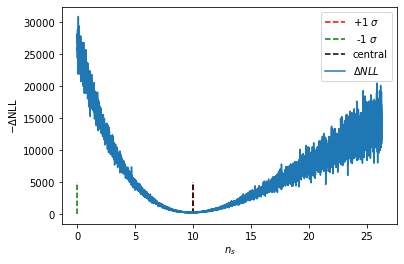

In [111]:
y = NLL 
mu = ns

cen = mu[np.argmin(y)] ## central value
cenlow = mu[np.argmax((y<1)*(mu< cen))] # -uncertainty
cenhig = mu[np.argmax((y>1)*(mu>cen))]# uncertainty

plt.plot([cenhig, cenhig], [0,5000],'r--', label= '+1 $\sigma$')
plt.plot([cenlow, cenlow], [0,5000], 'g--', label =' -1 $\sigma$')
plt.plot([cen,cen], [0,5000], 'k--', label = 'central')

plt.plot(ns, y, label = '$\Delta{NLL}$' )
plt.legend( loc = 'upper right')
#plt.xlim(0,3)
#plt.ylim(0, 1000)

print("The central value of mu is {:4.2f}".format(cen))
print("The minus one sigma error of mu is {:4.2f}".format(cen-cenlow))
print("The plus one sigma error of mu is {:4.2f}".format(cen-cenhig))

plt.xlabel('$n_s$')
plt.ylabel('$-\Delta$NLL')